In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, SymLogNorm
from scipy.spatial import cKDTree
from string import ascii_lowercase

import discretize 

from simpeg import (
    maps,
    utils
) 

from simpeg.electromagnetics import frequency_domain as fdem

In [2]:
Solver = utils.solver_utils.get_default_solver()

In [42]:
mesh = discretize.TreeMesh.read_UBC("J/octree_mesh_casing.txt")
conductivity_model = discretize.TreeMesh.read_model_UBC(mesh, "J/model_casing.con")

In [4]:
jx_e3d = np.loadtxt("J/J_X.txt")
jy_e3d = np.loadtxt("J/J_Y.txt")
jz_e3d = np.loadtxt("J/J_Z.txt")

In [5]:
def match_values_nearest(e3d_values, edges):
    
    # separate coordinates and values
    j_coords = e3d_values[:, :3]
    j_values = e3d_values[:, 3]
    
    # build a KDTree on J_X coordinates
    tree = cKDTree(j_coords)
    
    # query the nearest neighbor for each edge point
    distances, indices = tree.query(edges)
    
    # get the values from J_X corresponding to nearest neighbors
    matched_values = j_values[indices]
    
    return matched_values

In [6]:
jx = match_values_nearest(jx_e3d, mesh.edges_x)
jy = match_values_nearest(jy_e3d, mesh.edges_y)
jz = match_values_nearest(jz_e3d, mesh.edges_z)

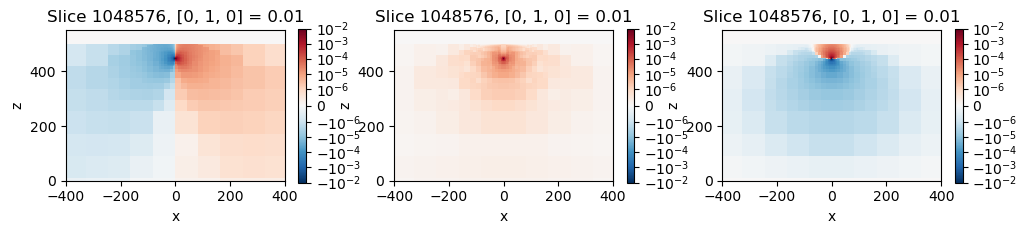

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))

for a, j, comp in zip(ax, [jx, jy, jz], ["x", "y", "z"]): 
    cb = plt.colorbar(mesh.plot_slice(
        getattr(mesh, f"average_edge_{comp}_to_cell") * j, 
        ax=a,
        normal="y", 
        pcolor_opts={"norm":SymLogNorm(vmin=-1e-2, vmax=1e-2, linthresh=1e-6), "cmap":"RdBu_r"},
    )[0], ax=a)
    a.set_xlim(np.r_[-1, 1]*400)
    a.set_ylim(np.r_[0, 550])
    a.set_aspect(1)

In [12]:
# load predicted data 
data_path = "points"

In [13]:
data_locs = np.loadtxt(f"{data_path}/points.txt")
data_e3d = np.loadtxt(f"{data_path}/dpredFWD.txt")

In [17]:
data_e3d_x = data_e3d[::2, :]
data_e3d_y = data_e3d[1::2, :]

In [23]:
rx_x = np.unique(data_locs[:, 0])
rx_y = np.unique(data_locs[:, 1])

In [27]:
data_locs[:, 0].reshape((len(rx_x), len(rx_y)), order="F")

array([-75. , -72.5, -70. , -67.5, -65. , -62.5, -60. , -57.5, -55. ,
       -52.5, -50. , -47.5, -45. , -42.5, -40. , -37.5, -35. , -32.5,
       -30. , -27.5, -25. , -22.5, -20. , -17.5, -15. , -12.5, -10. ,
        -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,  10. ,  12.5,
        15. ,  17.5,  20. ,  22.5,  25. ,  27.5,  30. ,  32.5,  35. ,
        37.5,  40. ,  42.5,  45. ,  47.5,  50. ,  52.5,  55. ,  57.5,
        60. ,  62.5,  65. ,  67.5,  70. ,  72.5,  75. ])

'x'

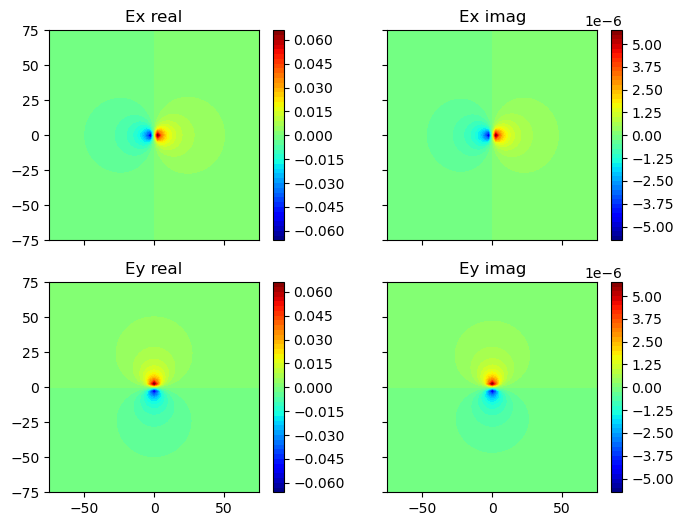

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

for i, data_plot in enumerate([data_e3d_x, data_e3d_y]):
    for j, comp in enumerate(["real", "imag"]): 
        plt.colorbar(
            ax[i, j].contourf(
                rx_x, rx_y, data_plot[:, j].reshape(len(rx_x), len(rx_y), order="F"), levels=50,
                cmap="jet"
            ), ax=ax[i, j]
        )
        ax[i, j].set_title(f"E{ascii_lowercase[23+i]} {comp}")
for a in ax.flatten(): 
    a.set_aspect(1)

In [44]:
# setup and run simulation 

In [47]:
rx_list = [
    fdem.receivers.PointElectricField(locations=data_locs, orientation="x", component="real"),
    fdem.receivers.PointElectricField(locations=data_locs, orientation="x", component="imag"),
    fdem.receivers.PointElectricField(locations=data_locs, orientation="y", component="real"),
    fdem.receivers.PointElectricField(locations=data_locs, orientation="y", component="imag"),
]

In [48]:
gravity_acceleration = 9.81 
density_water = 1000.0 
coupling_coefficient = 1e-5

In [53]:
frequency = 1 

In [67]:
jsrc = (
    # -coupling_coefficient / (density_water*gravity_acceleration) * 
    np.hstack([jx, jy, jz])
)

In [68]:
source = fdem.sources.RawVec_e(
    s_e = jsrc,
    frequency = frequency, 
    integrate = True,
    receiver_list = rx_list,
)

In [69]:
survey = fdem.Survey([source])

In [70]:
sim = fdem.Simulation3DElectricField(
    mesh=mesh, 
    survey=survey,
    solver=Solver, 
    sigma=conductivity_model,
)

In [75]:
sim.MeSigmaDeriv?

Signature: sim.MeSigmaDeriv(u, v=None, adjoint=False)
Docstring: Derivative of `MeProperty` with respect to the model.
File:      ~/miniforge3/envs/sp-csem-inv/lib/python3.11/site-packages/simpeg/base/pde_simulation.py
Type:      method

In [71]:
%%time
dpred = sim.make_synthetic_data(None)

/Users/lindseyjh/miniforge3/envs/sp-csem-inv/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


CPU times: user 5min 43s, sys: 21 s, total: 6min 4s
Wall time: 45 s


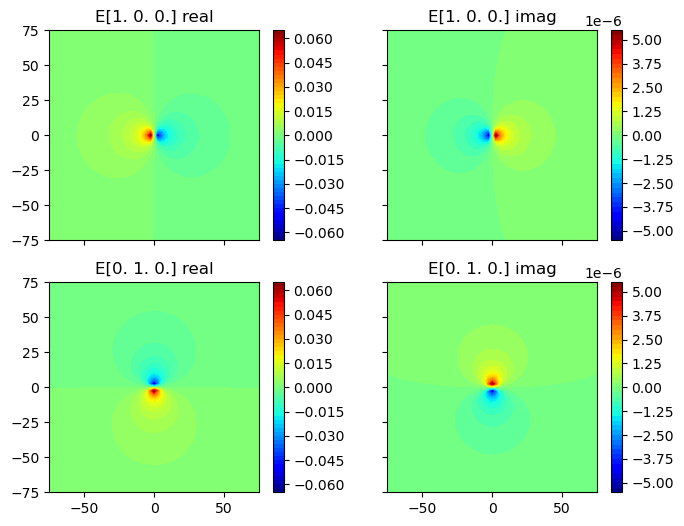

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

for a, rx in zip(ax.flatten(), rx_list):
    plt.colorbar(
        a.contourf(
            rx_x, rx_y, dpred[source, rx].reshape(len(rx_x), len(rx_y), order="F"), levels=50,
            cmap="jet"
        ), ax=a
    )
    a.set_title(f"E{rx.orientation} {rx.component}")

    a.set_aspect(1)

# set up class for inversion 

In [74]:
np.allclose(np.r_[0, 0, 0], 0)

True